In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cifar10-final-test/SMOTEd_NK/final_model.pth
/kaggle/input/cifar10-final-test/SMOTEd_NK/bst_model.pth
/kaggle/input/cifar10-final-test/No_Synthetic_AE/final_model.pth
/kaggle/input/cifar10-final-test/No_Synthetic_AE/bst_model.pth
/kaggle/input/cifar10-final-test/test_lab_imb/test_lab_imb
/kaggle/input/cifar10-final-test/test_img/test_img
/kaggle/input/cifar10-final-test/test_img_imb/test_img_imb
/kaggle/input/cifar10-final-test/test_lab/test_lab


In [2]:
!pip install -U imbalanced-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 7.0 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.10.1
    Uninstalling imbalanced-learn-0.10.1:
      Successfully uninstalled imbalanced-learn-0.10.1


In [3]:
import torch, torchvision
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from imblearn.metrics import geometric_mean_score
# from sklearn.model_selection import train_test_split

In [4]:
from torch.utils.data import Dataset
import PIL.Image as Image

# Method 1: define customDataset class, succeed from Dataset class
class customDataset(Dataset):
    def __init__(self, datapath, labelpath, transform=None):
        # --------------------------------------------
        # load file from paths, check dtype, reshape, transform, prepare array-like object for getitem method
        # --------------------------------------------
        
        dec_x = np.loadtxt(datapath)
        dec_y = np.loadtxt(labelpath)
        dec_y = dec_y.astype('long')
        dec_x = dec_x.reshape(dec_x.shape[0], 3, 32, 32) # channel-first image
        
        #PIL_x = Image.fromarray(dec_x)
        #PIL_x = Image.fromarray(np.uint8(dec_x), mode='RGB')
        #tensor_y = torch.tensor(dec_y,dtype=torch.long)
        
        self.transform = transform
        
        self.imgs = dec_x
        self.labs = dec_y       
        
    def __getitem__(self, index):
        # --------------------------------------------
        # 1. Use index to get item from array-like object
        # 2. Preprocess the data (PIL.Image, torchvision.Transform).
        # 3. Return the data (e.g. image and label)
        # --------------------------------------------
        imgcf = self.imgs[index] # shape = (3, 32, 32), channel-first
        #print('the shape of np_imgcf: {}'.format(imgcf.shape)) # the shape of np_img: (3, 32, 32)
        imgcl = np.moveaxis(imgcf, 0, -1)  # change to channel-last
        #print('the shape of np_imgcl: {}'.format(imgcl.shape)) # the shape of np_img: (32, 32, 3)
        
        imgcl = (imgcl + 1) / 2 * 255 # denormalize to fit Image.fromarray()
        #print('the max of np_img: {}'.format(imgcl.max()))   # 255
        #print('the min of np_img: {}'.format(imgcl.min()))   # 0  
        img = Image.fromarray(np.uint8(imgcl), mode='RGB')
        #print('the size of img: {}'.format(img.size))      # (32, 32)
        
        
        lab = self.labs[index]
        if self.transform is not None:
            img = self.transform(img)
        return img, lab
        
        
    def __len__(self):
        # --------------------------------------------
        # Indicate the total size of the dataset
        # --------------------------------------------
        return len(self.imgs)

In [5]:
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.models import resnet18
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler

In [6]:
# device: 是否使用GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper parameter: epochs, batch size, learning rate
epochs = 100
epoch_count = 0
bs = 128
lr = 0.001

# Load Data and data processing
#If the image is torch Tensor, it is expected to have […, H, W] shape,

#modpath = '/kaggle/input/cifar10-final-test/bst_model.pth'
modpath = '/kaggle/input/cifar10-final-test/No_Synthetic_AE/bst_model.pth'

test_dpath = '/kaggle/input/cifar10-final-test/test_img/test_img'
test_lpath = '/kaggle/input/cifar10-final-test/test_lab/test_lab'
imb_test_dpath = '/kaggle/input/cifar10-final-test/test_img_imb/test_img_imb'
imb_test_lpath = '/kaggle/input/cifar10-final-test/test_lab_imb/test_lab_imb'

transform_test = transforms.Compose([
    #transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    #transforms.Normalize((0.1307,), (0.3081,)),
])


testset = customDataset(test_dpath,test_lpath, transform=transform_test)
imbtestset = customDataset(imb_test_dpath,imb_test_lpath, transform=transform_test)
testloader = DataLoader(testset, batch_size=100, shuffle=True, num_workers=2)
imbtestloader = DataLoader(imbtestset, batch_size=100, shuffle=True, num_workers=2)


# Class labels
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

test_accuracy = []

In [7]:

# Final Testing

print("Final balanced Testing Start!")
# Model instantiation
model = resnet18()

# [MNIST-only] change default in_channel from 3 to 1
#model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False) 

# change fc layer 
# the number of classes in our dataset is 10. default is 1000.
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)
model.load_state_dict(torch.load(modpath), strict=False)
model = model.to(device)
print('Ready to Test!')





Final balanced Testing Start!
Ready to Test!


In [8]:
'''
# F1-score

with torch.no_grad():
    #correct = 0
    #total = 0
    
    for data in imbtestloader:
        model.eval()
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, dim=1)
        #total += labels.size(0)
        #correct += (predicted == labels).sum()
        labels = labels.cpu().numpy()
        predicted = predicted.cpu().numpy()
        f1 = metrics.f1_score(labels, predicted, average='macro')
        print('F1 Score: {:.3%}'.format(f1))
        acc = f1
        acc = acc.item()
        test_accuracy.append(acc)
'''

"\n# F1-score\n\nwith torch.no_grad():\n    #correct = 0\n    #total = 0\n    \n    for data in imbtestloader:\n        model.eval()\n        images, labels = data\n        images, labels = images.to(device), labels.to(device)\n        outputs = model(images)\n        _, predicted = torch.max(outputs.data, dim=1)\n        #total += labels.size(0)\n        #correct += (predicted == labels).sum()\n        labels = labels.cpu().numpy()\n        predicted = predicted.cpu().numpy()\n        f1 = metrics.f1_score(labels, predicted, average='macro')\n        print('F1 Score: {:.3%}'.format(f1))\n        acc = f1\n        acc = acc.item()\n        test_accuracy.append(acc)\n"

In [9]:
'''
# Average Class Specific Accuracy

with torch.no_grad():
    #correct = 0
    #total = 0
    
    for data in imbtestloader:
        model.eval()
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, dim=1)
        #total += labels.size(0)
        #correct += (predicted == labels).sum()
        labels = labels.cpu().numpy()
        predicted = predicted.cpu().numpy()
        matrix = metrics.confusion_matrix(labels, predicted, normalize='true')
        classacc = matrix.diagonal()
        #print('The Class Specific Accuracy: ' , classacc)
        #print('Length of classacc: ', len(classacc))
        #print('Sum of accuracy: ' , classacc.sum())
        acsa = classacc.sum() / len(classacc)
        print('ACSA: {:.3%}'.format(acsa))
        acc = acsa
        acc = acc.item()
        test_accuracy.append(acc)
'''

"\n# Average Class Specific Accuracy\n\nwith torch.no_grad():\n    #correct = 0\n    #total = 0\n    \n    for data in imbtestloader:\n        model.eval()\n        images, labels = data\n        images, labels = images.to(device), labels.to(device)\n        outputs = model(images)\n        _, predicted = torch.max(outputs.data, dim=1)\n        #total += labels.size(0)\n        #correct += (predicted == labels).sum()\n        labels = labels.cpu().numpy()\n        predicted = predicted.cpu().numpy()\n        matrix = metrics.confusion_matrix(labels, predicted, normalize='true')\n        classacc = matrix.diagonal()\n        #print('The Class Specific Accuracy: ' , classacc)\n        #print('Length of classacc: ', len(classacc))\n        #print('Sum of accuracy: ' , classacc.sum())\n        acsa = classacc.sum() / len(classacc)\n        print('ACSA: {:.3%}'.format(acsa))\n        acc = acsa\n        acc = acc.item()\n        test_accuracy.append(acc)\n"

In [10]:

# Geometric Mean

with torch.no_grad():
    #correct = 0
    #total = 0
    
    for data in imbtestloader:
        model.eval()
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, dim=1)
        #total += labels.size(0)
        #correct += (predicted == labels).sum()
        labels = labels.cpu().numpy()
        predicted = predicted.cpu().numpy()
        gm = geometric_mean_score(labels, predicted, average='macro')
        print('GM: {:.3%}'.format(gm))
        acc = gm
        acc = acc.item()
        test_accuracy.append(acc)


GM: 66.637%
GM: 63.894%
GM: 55.351%
GM: 64.464%
GM: 75.914%
GM: 67.682%
GM: 72.659%
GM: 71.614%
GM: 72.583%
GM: 64.662%
GM: 64.580%
GM: 66.249%
GM: 66.160%
GM: 58.867%
GM: 61.862%
GM: 69.270%
GM: 68.206%
GM: 57.597%
GM: 61.106%
GM: 57.086%
GM: 61.955%
GM: 68.251%
GM: 63.258%


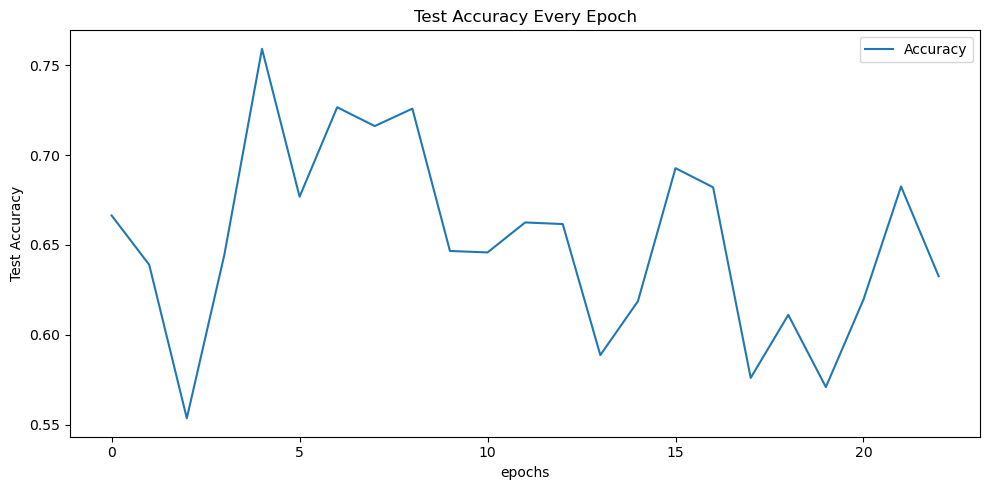

In [11]:
# Drawing

import matplotlib.pyplot as plt
%matplotlib inline 

plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True

plt.figure(figsize=(10,5))
plt.title("Test Accuracy Every Epoch")
plt.plot(test_accuracy,label="Accuracy")
plt.xlabel("epochs")
plt.ylabel("Test Accuracy")
plt.legend()
plt.savefig('Accuracy.png')
plt.show()

In [12]:
np.savetxt('results.txt', np.array(test_accuracy))

In [13]:
avg = sum(test_accuracy)/len(test_accuracy)
print(avg)

0.6521336301017225
